# Student Mental Health vs Academic Performance (CGPA)
This notebook documents an exploratory data analysis (EDA) of a student mental health survey dataset (from Kaggle).  
The goal is to **quantitatively evaluate whether academic performance (CGPA) is associated with mental health indicators** such as **depression** and **anxiety**.

> **Important note:** The dataset is **self-reported** and **observational**, so results show **associations/patterns**, not causation.


## 1. Setup & Load Data
We load the Excel dataset and preview the first few rows.

In [3]:
import pandas as pd
import numpy as np

# Load the dataset (Excel)
df = pd.read_excel("Student Mental health.xlsx")


df.head()



,Timestamp,Choose your gender,Age,What is your course?,Your current year of Study,What is your CGPA?,Marital status,Do you have Depression?,Do you have Anxiety?,Do you have Panic attack?,Did you seek any specialist for a treatment?
0,2020-08-07 12:02:00,Female,18.0,Engineering,year 1,3.00 - 3.49,No,Yes,No,Yes,No
1,2020-08-07 12:04:00,Male,21.0,Islamic education,year 2,3.00 - 3.49,No,No,Yes,No,No
2,2020-08-07 12:05:00,Male,19.0,BIT,Year 1,3.00 - 3.49,No,Yes,Yes,Yes,No
3,2020-08-07 12:06:00,Female,22.0,Laws,year 3,3.00 - 3.49,Yes,Yes,No,No,No
4,2020-08-07 12:13:00,Male,23.0,Mathemathics,year 4,3.00 - 3.49,No,No,No,No,No


## 2. Clean Column Names
To avoid KeyError issues, we standardize column names by stripping spaces, lowercasing, and replacing spaces with underscores.

In [4]:
# Clean column names
df.columns = (
    df.columns
      .str.strip()
      .str.lower()
      .str.replace(" ", "_")
      .str.replace("?", "", regex=False)
)

df.columns

Index(['timestamp', 'choose_your_gender', 'age', 'what_is_your_course',
       'your_current_year_of_study', 'what_is_your_cgpa', 'marital_status',
       'do_you_have_depression', 'do_you_have_anxiety',
       'do_you_have_panic_attack',
       'did_you_seek_any_specialist_for_a_treatment'],
      dtype='str')

## 3. Create Binary Indicators for Mental Health
Convert Yes/No columns into numeric (1/0) so we can run statistics and correlations.

In [5]:
# Convert Yes/No to 1/0
df['depression'] = (df['do_you_have_depression'] == 'Yes').astype(int)
df['anxiety'] = (df['do_you_have_anxiety'] == 'Yes').astype(int)
df['panic_attack'] = (df['do_you_have_panic_attack'] == 'Yes').astype(int)

# Overlap: depressed AND anxious
df['both_depression_anxiety'] = ((df['depression'] == 1) & (df['anxiety'] == 1)).astype(int)

df[['depression','anxiety','panic_attack','both_depression_anxiety']].head()

,depression,anxiety,panic_attack,both_depression_anxiety
0,1,0,1,0
1,0,1,0,0
2,1,1,1,1
3,1,0,0,0
4,0,0,0,0


## 4. Convert CGPA Ranges to Numeric Midpoints
The dataset stores CGPA as ranges (categorical). We map each range to a midpoint value for numeric analysis.

> If your dataset contains slightly different text (extra spaces), we strip strings before mapping.

In [6]:
# Clean CGPA text
df['what_is_your_cgpa'] = df['what_is_your_cgpa'].astype(str).str.strip()

# Map CGPA range -> numeric midpoint
cgpa_map = {
    '0 - 1.99': 1.0,         # approx midpoint
    '2.00 - 2.49': 2.25,
    '2.50 - 2.99': 2.75,
    '3.00 - 3.49': 3.25,
    '3.50 - 4.00': 3.75
}

df['cgpa_numeric'] = df['what_is_your_cgpa'].map(cgpa_map)

df[['what_is_your_cgpa','cgpa_numeric']].drop_duplicates().sort_values('cgpa_numeric')

,what_is_your_cgpa,cgpa_numeric
43,0 - 1.99,1.00
35,2.00 - 2.49,2.25
8,2.50 - 2.99,2.75
0,3.00 - 3.49,3.25
5,3.50 - 4.00,3.75


## 5. Prevalence of Depression / Anxiety / Overlap
Compute the percentage of students who report depression, anxiety, and both at the same time.

In [7]:
percentage_depressed = df['depression'].mean() * 100
percentage_anxious = df['anxiety'].mean() * 100
percentage_both = df['both_depression_anxiety'].mean() * 100

percentage_depressed, percentage_anxious, percentage_both

(np.float64(34.65346534653465),
 np.float64(33.663366336633665),
 np.float64(17.82178217821782))

## 6. Basic Visualizations
Simple count plots for depression and anxiety, plus a CGPA distribution chart (using numeric midpoints).

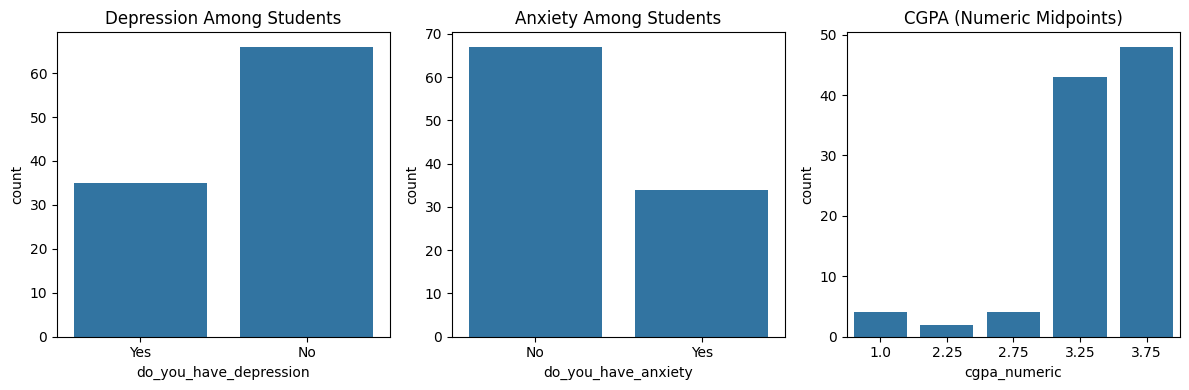

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

sns.countplot(data=df, x='do_you_have_depression', ax=axes[0])
axes[0].set_title("Depression Among Students")

sns.countplot(data=df, x='do_you_have_anxiety', ax=axes[1])
axes[1].set_title("Anxiety Among Students")

sns.countplot(data=df, x='cgpa_numeric', ax=axes[2])
axes[2].set_title("CGPA (Numeric Midpoints)")

plt.tight_layout()
plt.show()

## 7. Spearman Correlation (Mixed Numeric/Binary)
We use **Spearman correlation** to evaluate monotonic relationships and handle mixed variable types better than Pearson in this context.

In [9]:
corr_vars = ['age', 'cgpa_numeric', 'depression', 'anxiety', 'panic_attack']
spearman_corr = df[corr_vars].corr(method='spearman')
spearman_corr

,age,cgpa_numeric,depression,anxiety,panic_attack
age,1.000000,-0.029319,-0.057578,-0.094490,0.061818
cgpa_numeric,-0.029319,1.000000,-0.113802,0.118976,0.089003
depression,-0.057578,-0.113802,1.000000,0.273764,0.246842
anxiety,-0.094490,0.118976,0.273764,1.000000,0.084478
panic_attack,0.061818,0.089003,0.246842,0.084478,1.000000


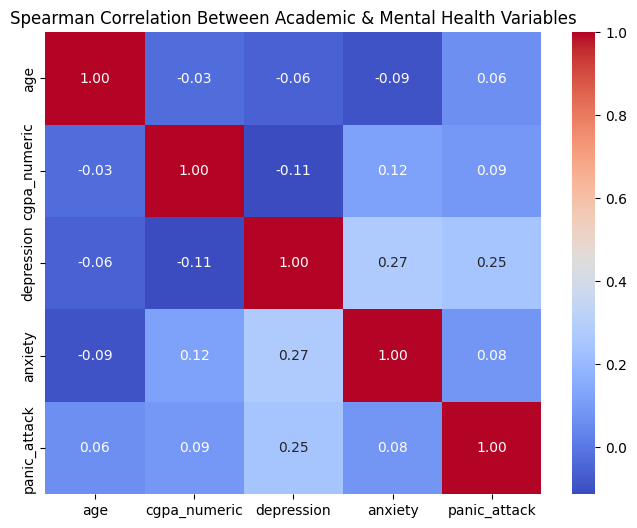

In [10]:
plt.figure(figsize=(8, 6))
sns.heatmap(spearman_corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Spearman Correlation Between Academic & Mental Health Variables")
plt.show()

## 8. Chi-square Test: CGPA Category × Depression
Chi-square checks whether **depression rates differ across CGPA categories** (categorical association).

In [11]:
from scipy.stats import chi2_contingency

cont_table = pd.crosstab(df['what_is_your_cgpa'], df['do_you_have_depression'])
chi2, p, dof, expected = chi2_contingency(cont_table)

chi2, p, dof

(np.float64(8.997499706365986), np.float64(0.061162006797657424), 4)

## 9. Depression Rate by CGPA Category
This provides an easy-to-read summary of depression prevalence within each CGPA band.

In [12]:
cgpa_depression_rate = (
    df.groupby('what_is_your_cgpa')['do_you_have_depression']
      .apply(lambda x: (x == 'Yes').mean() * 100)
      .sort_index()
)

cgpa_depression_rate

what_is_your_cgpa
0 - 1.99        0.000000
2.00 - 2.49     0.000000
2.50 - 2.99    75.000000
3.00 - 3.49    44.186047
3.50 - 4.00    27.083333
Name: do_you_have_depression, dtype: float64

## 10. Logistic Regression (Statsmodels)
We model **depression (0/1)** using predictors such as **CGPA** and **age**.

> `statsmodels` requires no missing values in predictors, so we drop rows with missing values in the modeling columns.

In [13]:
import statsmodels.api as sm

model_df = df[['depression', 'cgpa_numeric', 'age']].dropna()

X = model_df[['cgpa_numeric', 'age']]
X = sm.add_constant(X)

y = model_df['depression']

logit_model = sm.Logit(y, X).fit()
logit_model.summary()

Optimization terminated successfully.
         Current function value: 0.644715
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             depression   No. Observations:                  100
Model:                          Logit   Df Residuals:                       97
Method:                           MLE   Df Model:                            2
Date:                Mon, 09 Feb 2026   Pseudo R-squ.:                0.004220
Time:                        21:11:44   Log-Likelihood:                -64.471
converged:                       True   LL-Null:                       -64.745
Covariance Type:            nonrobust   LLR p-value:                    0.7609
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.4457      2.212      0.202      0.840      -3.889       4.781
cgpa_numeric     0.0587      0.400      0.147      0.883      -0.725       0.842
age             -0.0617      0.086     -0.721      0.471      -0.229       0.106
================================================================================
"""

### Optional: Odds Ratios
Odds ratios are easier to interpret than raw logistic coefficients.

In [14]:
import numpy as np

odds_ratios = np.exp(logit_model.params)
odds_ratios

const           1.561547
cgpa_numeric    1.060440
age             0.940153
dtype: float64

## 11. Summary of Key Takeaways
- Depression, anxiety, and panic attacks show **stronger relationships with each other** than with CGPA.
- CGPA shows **weak association** with mental health indicators (Spearman correlations near 0).
- A chi-square test can be statistically significant even when correlation strength is small.
- Logistic regression results (p-values, pseudo R²) help confirm whether CGPA meaningfully predicts depression.

This notebook is designed to be a documented, reproducible record of the analysis used for a Medium article or project portfolio.